In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from utils import name_generator
import scipy.stats as stats
import pymc as pm
import arviz as az
import corner

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [26]:
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)

# True parameter values
true_alpha = 1 #constant
true_sigma = 1 # noise
true_beta = np.array([1, 2]) #coeficcient 1

# Size of dataset
size = 100

# Predictor variable
X1 = np.random.randn(2, size)

# Simulate outcome variable
Y = true_alpha + true_beta[:, np.newaxis] * X1 + rng.normal(scale=true_sigma, size=(2, size))

In [30]:
basic_model = pm.Model()
with basic_model:
    # Priors for unknown model parameters, assuming separate parameters for each dimension
    alpha = pm.Normal("alpha", mu=0, sigma=10, shape=(2, 1))  # Shape specified for 2 dimensions
    beta = pm.Normal("beta", mu=0, sigma=10, shape=(2, 1))  # Shape specified for compatibility with X1
    sigma = pm.HalfNormal("sigma", sigma=1, shape=(2, 1))  # Shape specified for 2 dimensions

    # Expected value of outcome, performing element-wise operations
    # Reshape or broadcast parameters as necessary to match the 2D structure of X1
    mu = alpha + beta * X1  # Ensure this operation respects the 2D shapes

    # Likelihood (sampling distribution) of observations, directly using 2D Y
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y)  # Y is specified directly as 2D

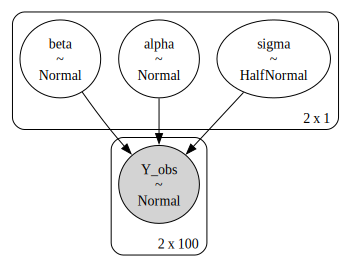

In [31]:
pm.model_to_graphviz(basic_model)

In [32]:
with basic_model:
    # draw 1000 posterior samples
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 203 seconds.


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

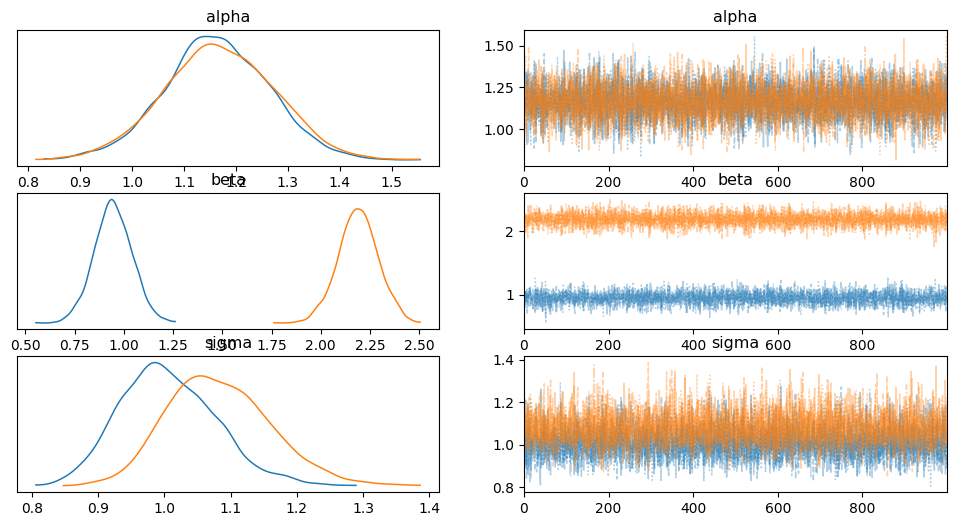

In [33]:
az.plot_trace(idata, combined=True)

In [34]:
az.summary(idata, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"alpha[0, 0]",1.16,0.10,0.98,1.35,0.0,0.0,5605.26,3209.99,1.0
"alpha[1, 0]",1.17,0.11,0.96,1.36,0.0,0.0,5488.67,3360.31,1.0
"beta[0, 0]",0.95,0.10,0.76,1.13,0.0,0.0,4176.00,3053.78,1.0
"beta[1, 0]",2.19,0.10,1.99,2.38,0.0,0.0,5438.33,3219.68,1.0
"sigma[0, 0]",1.01,0.07,0.87,1.14,0.0,0.0,5114.04,2846.74,1.0
"sigma[1, 0]",1.08,0.08,0.94,1.23,0.0,0.0,5919.55,2820.81,1.0


ValueError: Provided figure has 36 axes, but data has dimensions K=4

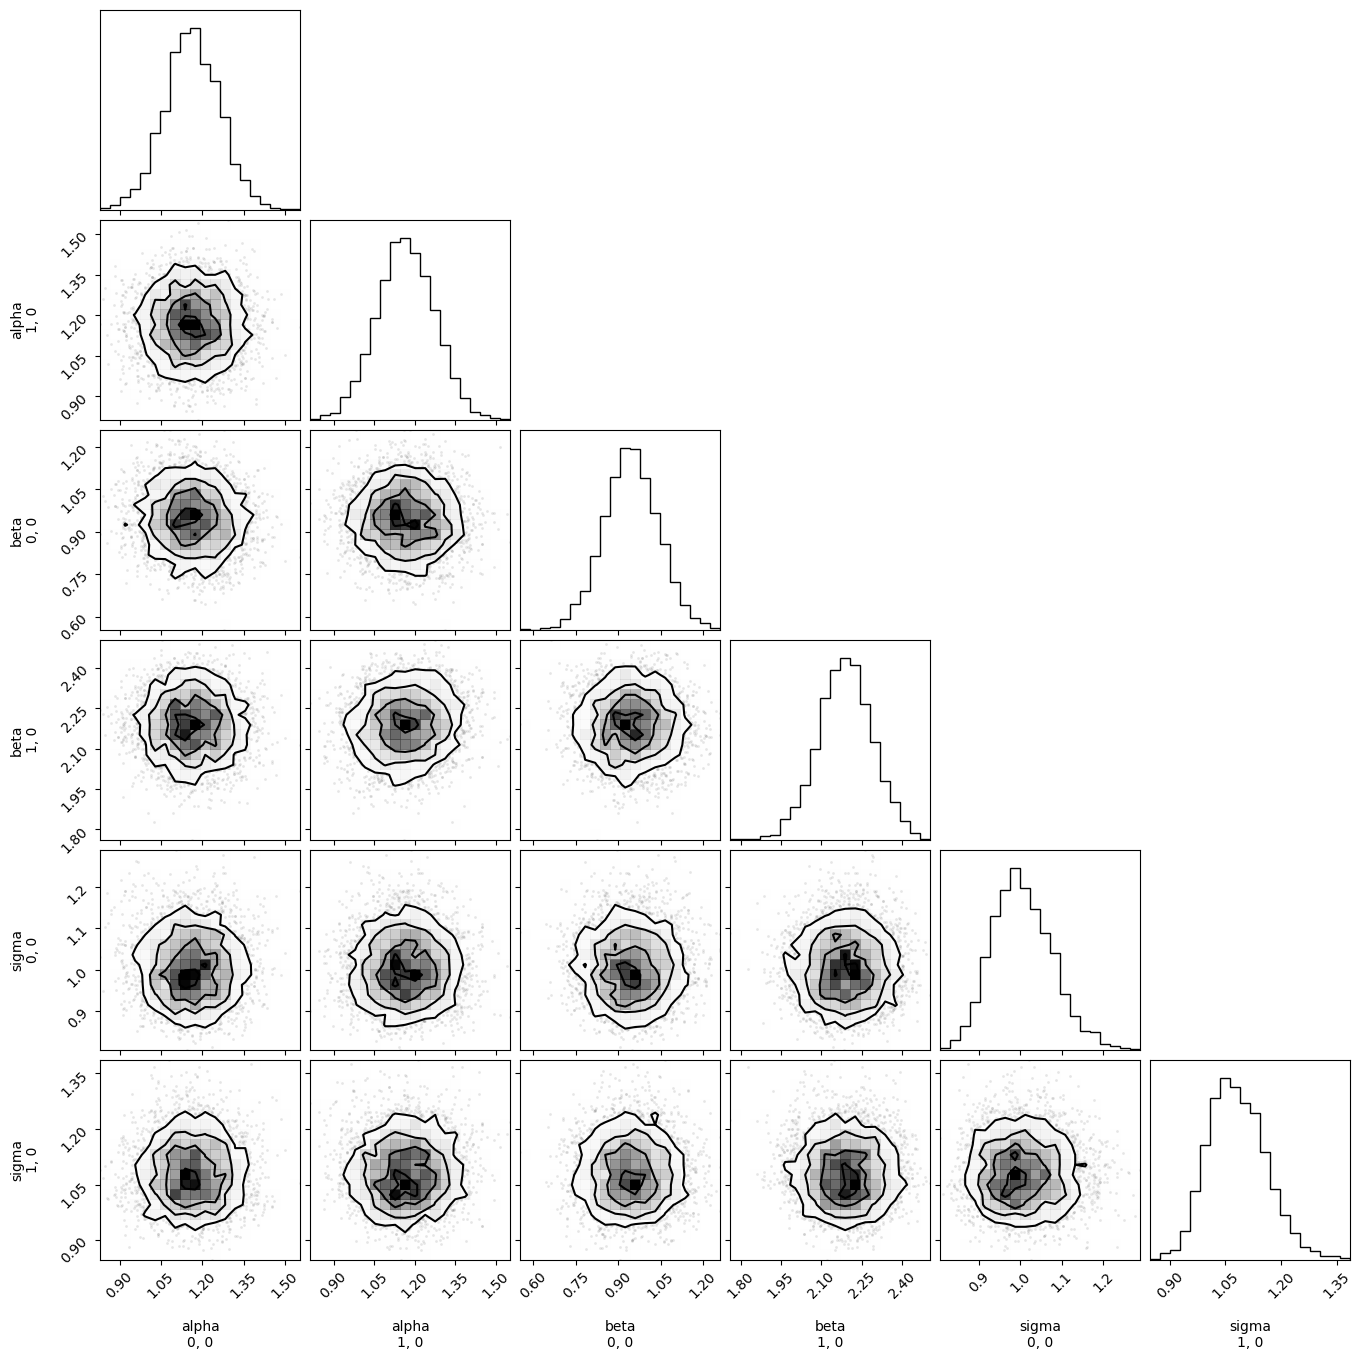

In [36]:
import corner

_ = corner.corner(
    idata,
    truths=dict(alpha=true_alpha, sigma=true_sigma, beta=true_beta),
)